# Recommendation system using Content based filtering approach


**Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

**Reading Data**

In [5]:
data = pd.read_csv('/content/take_home_ss_ratings.csv')

In [6]:
data.head()

,user_id,quiz_type,quiz_number,question_number,item_id,rating
0,0,random,0,0,45,1
1,0,random,0,1,734,1
2,0,random,0,2,4145,1
3,0,random,0,3,3231,0
4,0,random,0,4,361,1


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116370 entries, 0 to 1116369
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   user_id          1116370 non-null  int64 
 1   quiz_type        1116370 non-null  object
 2   quiz_number      1116370 non-null  int64 
 3   question_number  1116370 non-null  int64 
 4   item_id          1116370 non-null  int64 
 5   rating           1116370 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 51.1+ MB


**Frequency Barplot of Ratings**

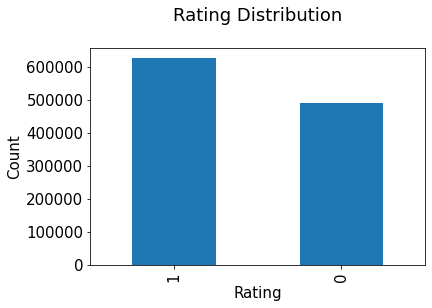

In [9]:
plt.rc("font", size=15)
data.rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

The Data does not have any NA values, outliers (presence of categorical features) or any imbalance. As a result, the data can be used for modeling. 

**Finding the rating Counts of each Item Id**

In [10]:
rating_count = pd.DataFrame(data.groupby('item_id')['rating'].count())
rating_count.sort_values('rating', ascending=False).head()

,rating
item_id,
1279,406
1540,403
1253,400
2582,395
3531,394


**Finding the average rating, and the number of ratings each Item received**

In [11]:
average_rating = pd.DataFrame(data.groupby('item_id')['rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(data.groupby('item_id')['rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,rating,ratingCount
item_id,,
1279,0.849754,406
1540,0.856079,403
1253,0.847500,400
2582,0.746835,395
3531,0.885787,394


Observations: In this data set, the item that received the most rating counts was not highly rated. Hence, we need to dive deeper and take into consideration the similarities between the items to help users recommend items that they would like. This will be provide a better measure to build recommendation system and by recommending products that match user's preferance can help positively impact the business.

**To ensure statistical significance, filtering the data by considering those items that have a count greater than 250**

In [12]:
counts1 = data['item_id'].value_counts()
ratings = data[data['item_id'].isin(counts1[counts1 >= 250].index)]

In [13]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516410 entries, 0 to 1116369
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   user_id          516410 non-null  int64 
 1   quiz_type        516410 non-null  object
 2   quiz_number      516410 non-null  int64 
 3   question_number  516410 non-null  int64 
 4   item_id          516410 non-null  int64 
 5   rating           516410 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 27.6+ MB


**Collaborative Filtering Using k-Nearest Neighbors (KNN)**

kNN is a machine learning algorithm to find clusters of similar users based on common item ratings, and make predictions using the average rating of top-k nearest neighbors.

We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values (ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

In [14]:
ratings_pivot = ratings.pivot_table(index = 'user_id',columns = 'item_id', values = 'rating').fillna(0)
ratings_pivot_matrix = csr_matrix(ratings_pivot.values)

In [23]:
ratings_pivot.head(5)

item_id,5,8,9,16,20,23,25,31,33,35,37,38,42,45,47,50,53,54,55,58,59,62,63,66,70,82,83,88,90,94,104,105,106,107,111,112,116,118,119,120,...,4874,4883,4885,4886,4890,4894,4896,4901,4902,4906,4909,4910,4917,4918,4921,4924,4928,4929,4932,4936,4946,4950,4953,4954,4957,4963,4965,4966,4967,4968,4971,4972,4975,4977,4981,4982,4989,4990,4991,4996
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Used Cosine similarity as a metric to measure the similarity between the items.

In [36]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(ratings_pivot_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [38]:
query_index = np.random.choice(ratings_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(ratings_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 8)

1603


In [39]:
print('Current Item is {}'.format(ratings_pivot.index[query_index]))

Current Item is 1607


In [40]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for the item {0}:\n'.format(ratings_pivot.index[query_index]))
    else:
        print('{0}: Iteam {1}, with distance of {2}:'.format(i, ratings_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for the item 1607:

1: Iteam 1196, with distance of 0.5:
2: Iteam 6409, with distance of 0.5:
3: Iteam 4237, with distance of 0.5:
4: Iteam 1999, with distance of 0.6464466094067263:
5: Iteam 11357, with distance of 0.6984886554222364:
6: Iteam 8306, with distance of 0.6984886554222364:
7: Iteam 17907, with distance of 0.7113248654051871:
